In [1]:
%pip install --upgrade pip 
%pip install pandas
%pip install matplotlib
%pip install sklearn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import
import pandas as pd
import matplotlib.pyplot as mp
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from io import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.tree import _tree
import numpy as np
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
%matplotlib inline
label_encoder = LabelEncoder()

In [3]:
# Chargement CSV Train
train = pd.read_csv("data/train.csv", index_col=0)
train.tail()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [4]:
#Trie des données du train
train = train[train['Age'].notna()]
train = train[train['Sex'].notna()]
train = train[train['Pclass'].notna()]
train = train.drop(columns=['Name', 'Fare', 'Ticket' ,'Cabin'])

train['Sex']=label_encoder.fit_transform(train['Sex'])
train['Embarked']=label_encoder.fit_transform(train['Embarked'])

train.tail()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
PassengerId,,,,,,,
886,0,3,0,39.0,0,5,1
887,0,2,1,27.0,0,0,2
888,1,1,0,19.0,0,0,2
890,1,1,1,26.0,0,0,0
891,0,3,1,32.0,0,0,1


In [5]:
y = train['Survived']
y

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
886    0
887    0
888    1
890    1
891    0
Name: Survived, Length: 714, dtype: int64

In [6]:
X = train.drop(columns=['Survived'])
X

,Pclass,Sex,Age,SibSp,Parch,Embarked
PassengerId,,,,,,
1,3,1,22.0,1,0,2
2,1,0,38.0,1,0,0
3,3,0,26.0,0,0,2
4,1,0,35.0,1,0,2
5,3,1,35.0,0,0,2
...,...,...,...,...,...,...
886,3,0,39.0,0,5,1
887,2,1,27.0,0,0,2
888,1,0,19.0,0,0,2


In [7]:
#Split du train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
# Création du Decision Tree CLassifier
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7627118644067796


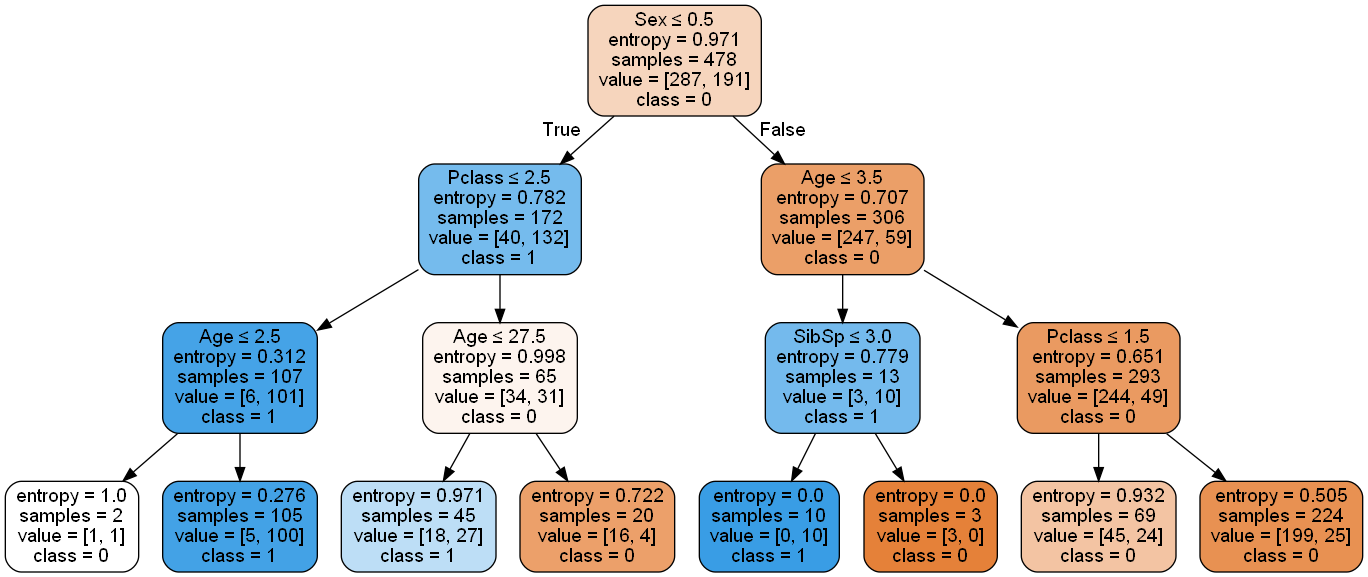

In [9]:
# Arbre de décision
feature_cols = ['Pclass', 'Sex','Age', 'SibSp',	'Parch', 'Embarked']


dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('test.png')
Image(graph.create_png())

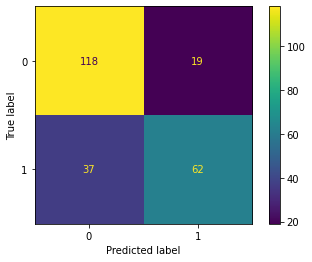

In [10]:
# Matrix de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()

In [11]:
# la methode pour afficher les règles
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [12]:
# l'afficage des règles

rules = get_rules(clf, feature_cols, None)
for r in rules:
    d = pd.DataFrame(data=rules)
d.tail()

,0
3,if (Sex <= 0.5) and (Pclass > 2.5) and (Age <=...
4,if (Sex <= 0.5) and (Pclass > 2.5) and (Age > ...
5,if (Sex > 0.5) and (Age <= 3.5) and (SibSp <= ...
6,if (Sex > 0.5) and (Age <= 3.5) and (SibSp > 3...
7,if (Sex <= 0.5) and (Pclass <= 2.5) and (Age <...
